<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the selected variables to help predict the on-court performance of a player (their average points scored per game). To do so, stats that are not directly related to performance will be used, like age, height, weight, and draft pick. The season variable will also allow player performances to be measured throughout time and compare NBA starts from all eras and styles of the game. All of these factors were selected because of their likelihood to correlate with stronger on-court performance.

Our question: How do our selected factors help to predict the individual performance of NBA players? 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. The data was acquired through the NBA API with missing information supplied by scraping from [another NBA source](https://www.basketball-reference.com/) (for this reason, the dataset was taken directly from Kaggle and not the original source). 

# Methods and Results

### Libraries

In [52]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

## Dataset Load & Preperation

After loading the dataset from the internet, we cann see that it contains 22 variables, the majority of which we can discard as categorical variables. Others cannot be used and several numeric variables are unsuited for this model.
We conduct analysis on the remaining selected variables to try and predict the average points a player will get per season using regression analysis. By first training a model on the training data for each respective datapoint category we will then be able too use the k-nearest neighbors algorithm to perform regression on the data and decide which of the columns provides the best predictor for a players performance.

In [53]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"

temp <- tempfile()

download.file(url, temp)
# read the dataset from temp file
player_data <- read_csv(temp)
head(player_data)

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,⋯,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Dennis Rodman,CHI,36,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,⋯,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28,215.90,117.93392,Florida,USA,1990,1,⋯,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39,205.74,95.25432,Detroit Mercy,USA,1979,3,⋯,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24,203.20,100.69742,UCLA,USA,1995,1,⋯,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34,205.74,108.86208,Villanova,USA,1985,1,⋯,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97
5,Eddie Johnson,HOU,38,200.66,97.52228,Illinois,USA,1981,2,⋯,8.2,2.7,1.0,4.1,0.034,0.126,0.220,0.541,0.102,1996-97


We focus only on the specific parameters to judge the overall performance of an NBA player, these include points (pts), the variable which we will be predicting, as well as rebounds (reb), and assists (ast), usage percentage (usg_pct), true shooting percentage (ts_pct), and their draft number (draft_number).

Additionally, players drafted in or before 2011 are excluded, to keep the data used recent and the dataset size manageable.

In [54]:
nba_players <- player_data |>
    filter(draft_year > 2011) |>
    select(pts, reb, ast, usg_pct, ts_pct, draft_number) |>
    # remove undrafted players with no draft number "Undrafted"
    filter(draft_number != "Undrafted") |>
    mutate(draft_number = as.numeric(draft_number))            
nba_players

pts,reb,ast,usg_pct,ts_pct,draft_number
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.3,1.6,0.3,0.198,0.417,28
4.0,2.7,0.4,0.146,0.632,37
1.3,0.3,0.4,0.199,0.349,38
⋮,⋮,⋮,⋮,⋮,⋮
1.9,1.1,0.0,0.247,0.428,44
10.8,2.7,5.5,0.265,0.517,1
12.1,3.8,5.9,0.179,0.540,6


Now we split the data into training and testing. We will use the training data to build our regression model and our testing data to measure how well our model performs.

In [55]:
set.seed("1234")
nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training

pts,reb,ast,usg_pct,ts_pct,draft_number
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3,0.3,0.4,0.199,0.349,38
1.3,1.1,0.2,0.134,0.407,60
2.6,0.8,1.2,0.213,0.461,25
⋮,⋮,⋮,⋮,⋮,⋮
12.1,2.9,1.5,0.189,0.544,19
28.4,9.1,8.7,0.368,0.571,3
12.1,3.8,5.9,0.179,0.540,6


# Dataset Visualization

We can now look at the correlation of multiple parameters compared with points per game. This will allow us to predict which parameters strongly influence overall points scored before we build our regression model. 

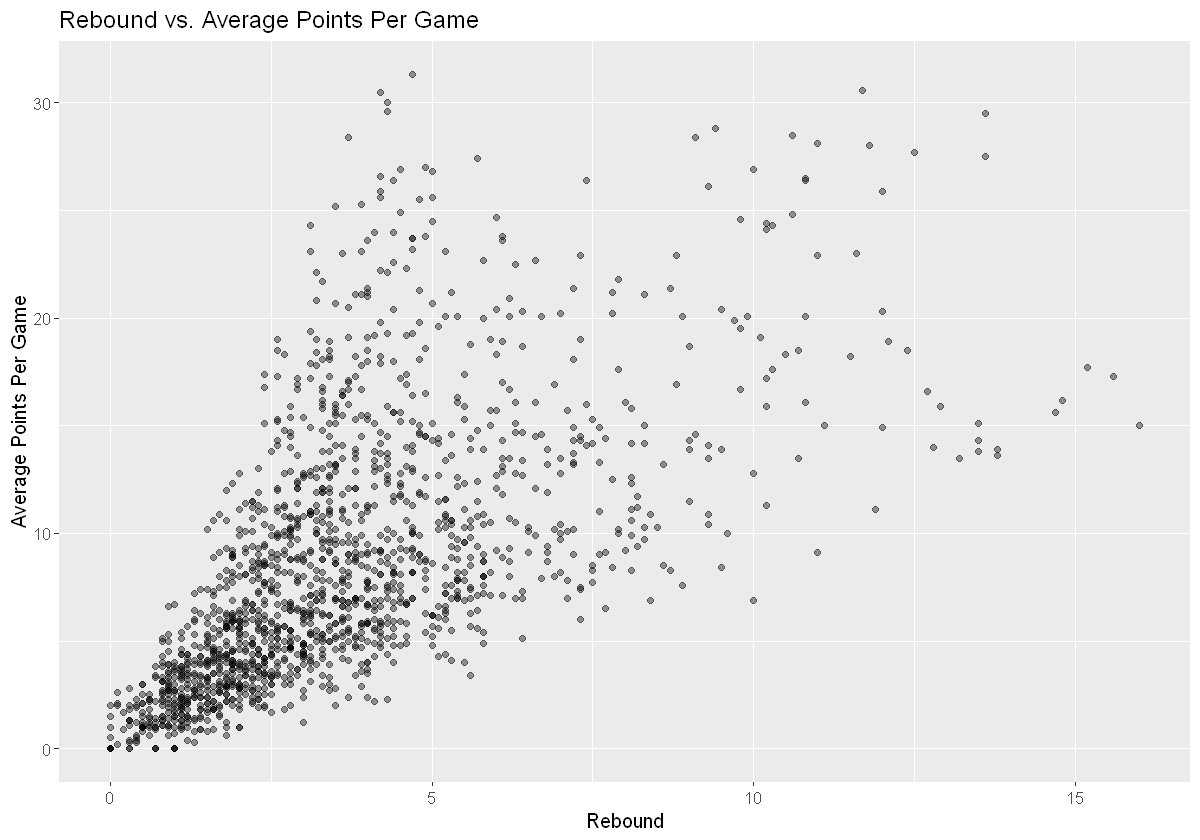

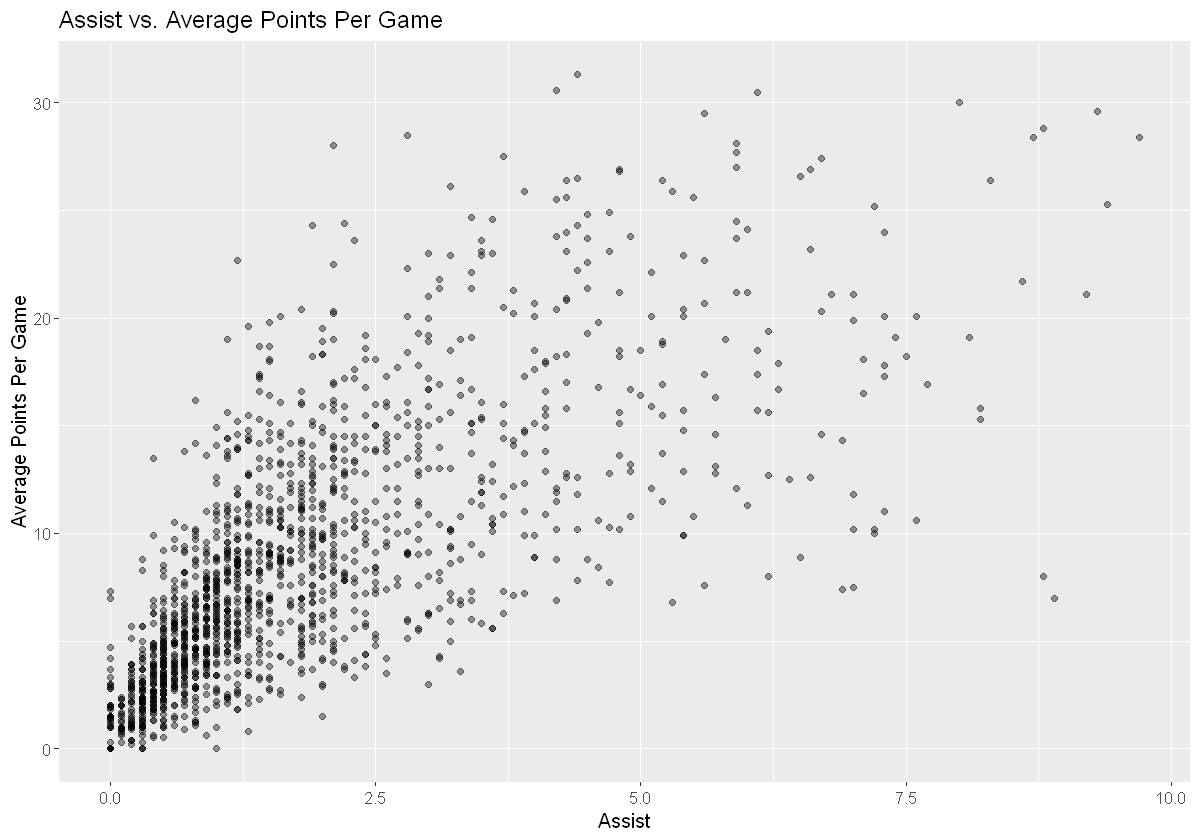

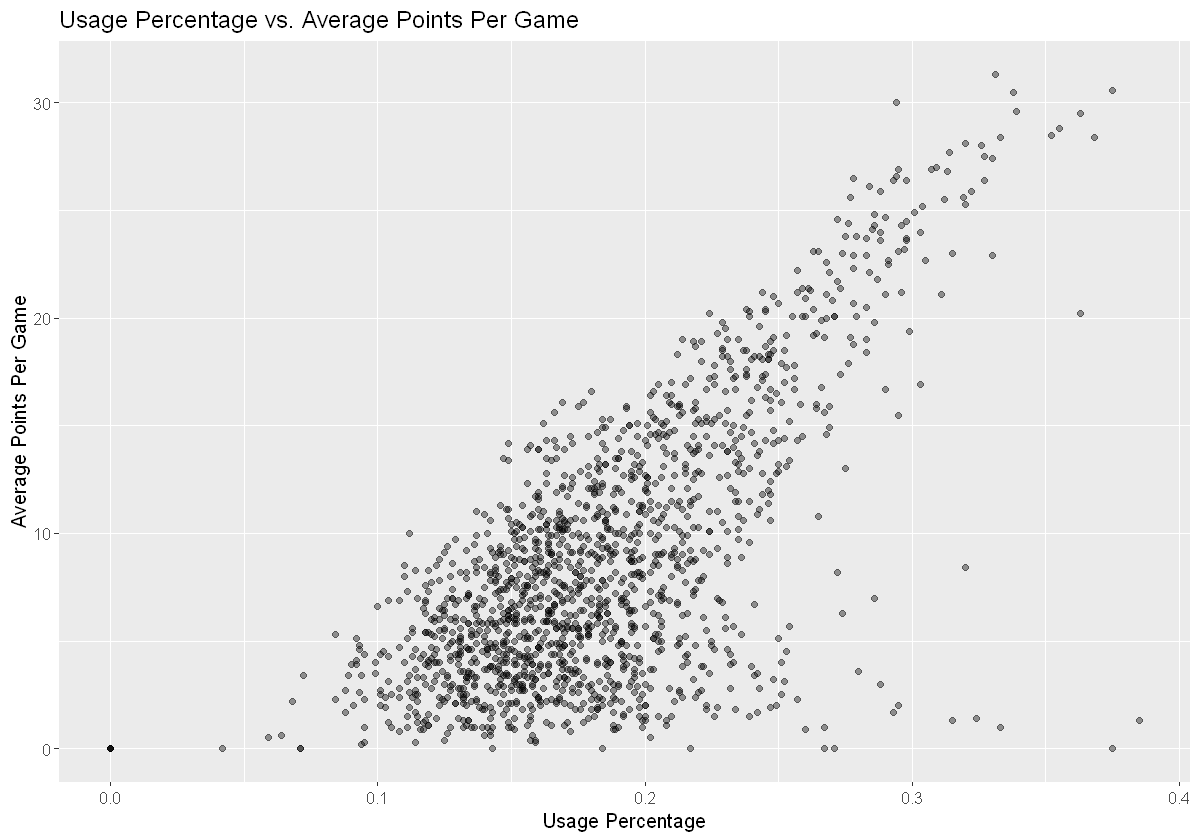

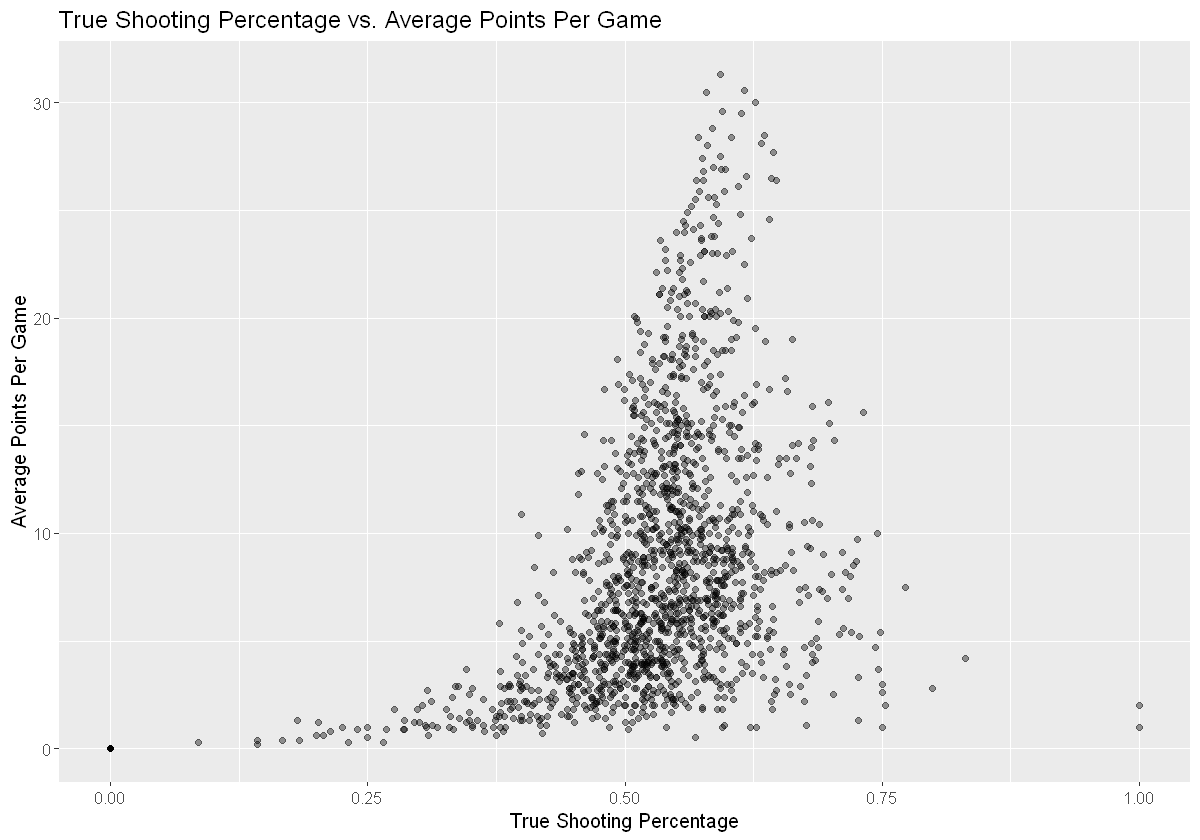

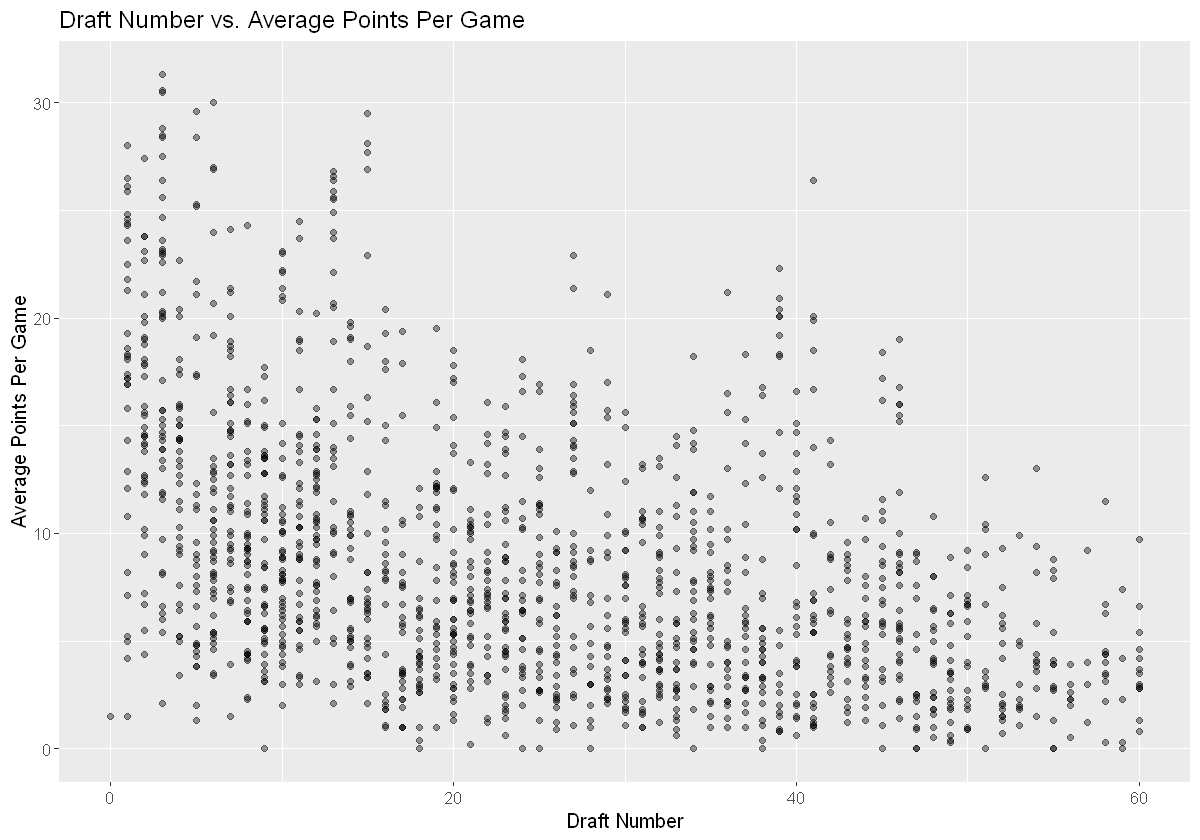

In [56]:
options(repr.plot.width = 10)

nba_plot_rebounds <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Rebound", y = "Average Points Per Game") +
ggtitle("Rebound vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_assists <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point(alpha = 0.4)+
labs(x = "Assist", y = "Average Points Per Game") +
ggtitle("Assist vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_usage_pct <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Usage Percentage", y = "Average Points Per Game") +
ggtitle("Usage Percentage vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_true_shooting_pct <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "True Shooting Percentage", y = "Average Points Per Game") +
ggtitle("True Shooting Percentage vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_number <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point(alpha = 0.4) +
labs(x = "Draft Number", y = "Average Points Per Game") +
ggtitle("Draft Number vs. Average Points Per Game") +
theme(text = element_text(size = 12))

nba_plot_rebounds
nba_plot_assists
nba_plot_usage_pct
nba_plot_true_shooting_pct
nba_plot_number

As shown in the visualizations above, usage percentage appears to have strong and somewhat linear relationship with points scored, which makes it potentially a good predictor. The other variables also exhibit trends, with rebounds and exists showing a positive relationship with points scored. Draft number seems to have a weak negative relationship, and true shooting percentage shows a distribution with the area with the highest points surrounding the centre of the graph. The lack of linearity with several of the variables supports the use of k-nearest neighbors for this data set over linear regression.

Shown below is the calculated means of the variables, as well as the total number of data points within the training set.

In [57]:
summarise_rebounds <- summarise(nba_training, mean_rebounds = mean(reb))
summarise_assists <- summarise(nba_training, mean_assists = mean(ast))
summarise_usage_pct <- summarise(nba_training, mean_usage = mean(usg_pct))
summarise_true_shooting_pct <- summarise(nba_training, mean_ts = mean(ts_pct))
summarise_draft_number <- nba_training |>
summarise(mean_number = mean(as.numeric(draft_number), na.rm = TRUE))
summarise_nrow <- summarise(nba_training, total_rows = nrow(nba_training))

combined_summary <- bind_cols(summarise_rebounds, summarise_assists, summarise_usage_pct,
summarise_true_shooting_pct, summarise_draft_number, summarise_nrow)


combined_summary

mean_rebounds,mean_assists,mean_usage,mean_ts,mean_number,total_rows
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3.658344,1.826637,0.1841367,0.5294891,24.57702,1558


## Data Analysis

To predict the player performance variable, we will be using k-nearest neighbors regression, as the relationships between the predictor variables and our performance variable are not all linear, and the performance variable is numeric.

First, we prepare the recipe, using rebounds, assists, usage percentage, and true shooting percentage to predict the points scored. These variables are all scaled before continuing.

In [58]:
nba_recipe <- recipe(pts ~ reb + ast + usg_pct + ts_pct + draft_number, data = nba_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

nba_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Then, we prepare the model. First, we will using tuning to determine the best number of neighbors to use, employing 5-fold cross-validation.

In [59]:
nba_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

nba_vfold <- vfold_cv(nba_training, v = 5, strata = pts)

nba_workflow <- workflow() |>
add_recipe(nba_recipe) |>
add_model(nba_spec)

nba_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We want to determine a general range that the best number of neighbors will lie in, so we begin at 1 and step up to 100 in increments of 5.

In [60]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

nba_results <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.465358,5,0.05056718,Preprocessor1_Model01
6,rmse,standard,1.968587,5,0.02970877,Preprocessor1_Model02
11,rmse,standard,1.980691,5,0.04172049,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,rmse,standard,2.508816,5,0.04418328,Preprocessor1_Model18
91,rmse,standard,2.531472,5,0.04571965,Preprocessor1_Model19
96,rmse,standard,2.554597,5,0.04540410,Preprocessor1_Model20


Then, we can select the number of neighbors from this list with the best predicted accuracy. Also shown is a graph of the number of neighbors vs. the mean RMSE.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,1.968587,5,0.02970877,Preprocessor1_Model02


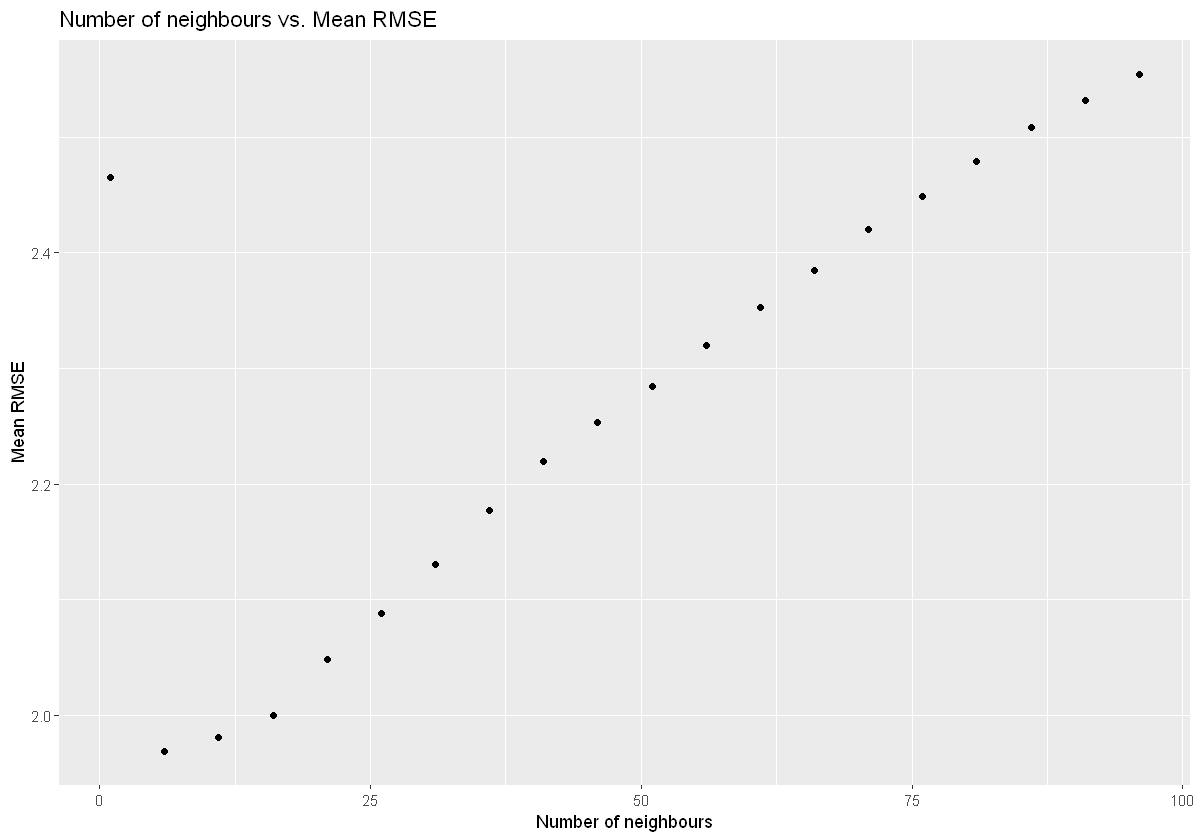

In [61]:
nba_k_plot <- ggplot(nba_results, aes(x = neighbors, y = mean)) +
geom_point() +
labs(x = "Number of neighbours", y = "Mean RMSE") +
ggtitle("Number of neighbours vs. Mean RMSE")

nba_k_plot

nba_k_initial <- nba_results |>
  filter(mean == min(mean))
nba_k_initial

To determine the single best value, we narrow down the range of neighbors we investigate to be between 1 and 15, and step by 1 to find the best value.

In [62]:
k_vals_narrow <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

nba_results_2 <- nba_workflow |>
  tune_grid(resamples = nba_vfold, grid = k_vals_narrow) |>
  collect_metrics() |>
  filter(.metric == "rmse")

nba_results_2

nba_smallest <- nba_results_2 |>
  filter(mean == min(mean))
nba_smallest


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.465358,5,0.05056718,Preprocessor1_Model01
2,rmse,standard,2.163768,5,0.02395023,Preprocessor1_Model02
3,rmse,standard,2.057456,5,0.01616706,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,rmse,standard,1.983384,5,0.04786824,Preprocessor1_Model13
14,rmse,standard,1.990664,5,0.04859549,Preprocessor1_Model14
15,rmse,standard,1.995340,5,0.05086106,Preprocessor1_Model15


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,1.94347,5,0.02747903,Preprocessor1_Model07


Next, we prepare the final model, using the optimal amount of neighbors.

In [63]:
neighbors_val <- nba_smallest |>
pull(neighbors)

nba_tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = neighbors_val) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_tuned_spec) |>
  fit(data = nba_training)

nba_predict <- nba_fit |>
  predict(nba_testing) |>
  bind_cols(nba_testing)

nba_rmse <- nba_predict |>
  metrics(truth = pts, estimate = .pred) |>
  filter(.metric == 'rmse')

nba_predict_select <- nba_predict |>
select(.pred, pts)

nba_predict_select

nba_rmse

.pred,pts
<dbl>,<dbl>
2.914286,2.3
4.628571,4.0
3.942857,4.0
⋮,⋮
5.085714,4.6
5.457143,5.7
12.671429,11.3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.933842


The final RMSPE for our model against the testing data is 1.9338. While this is still a significant amount of error, in the context of predicting sports performance, the predictions offered by our model are still useful. Visualization of the completed model's performance is difficult owing to the numerous variables involved. Below, each variable used to predict player score is depicted separately.

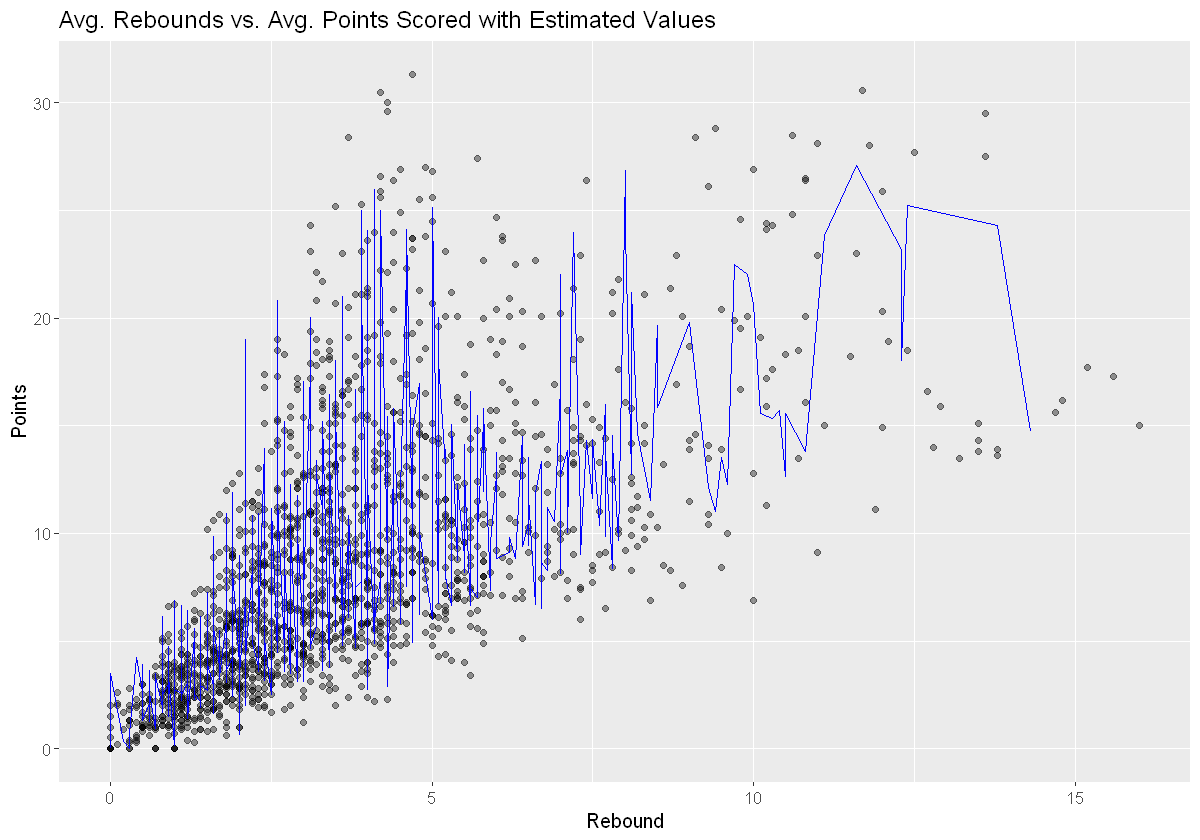

In [64]:
options(repr.plot.width = 10)
nba_predict_plot_rebound <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = reb, y = .pred), color = 'blue') +
labs(x = "Rebound", y = "Points") +
ggtitle("Avg. Rebounds vs. Avg. Points Scored with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_rebound

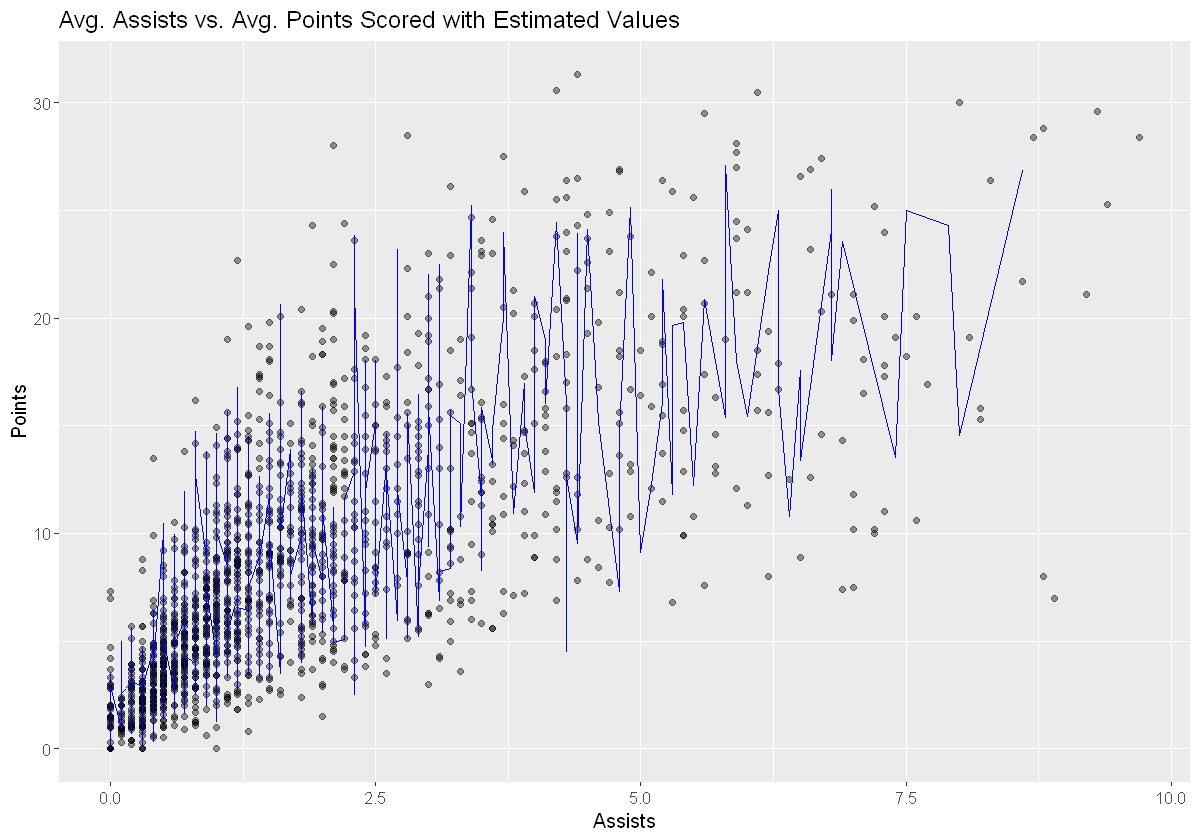

In [65]:
nba_predict_plot_assist <- ggplot(nba_training, aes(x = ast, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = ast, y = .pred), color = 'blue') +
labs(x = "Assists", y = "Points") +
ggtitle("Avg. Assists vs. Avg. Points Scored with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_assist

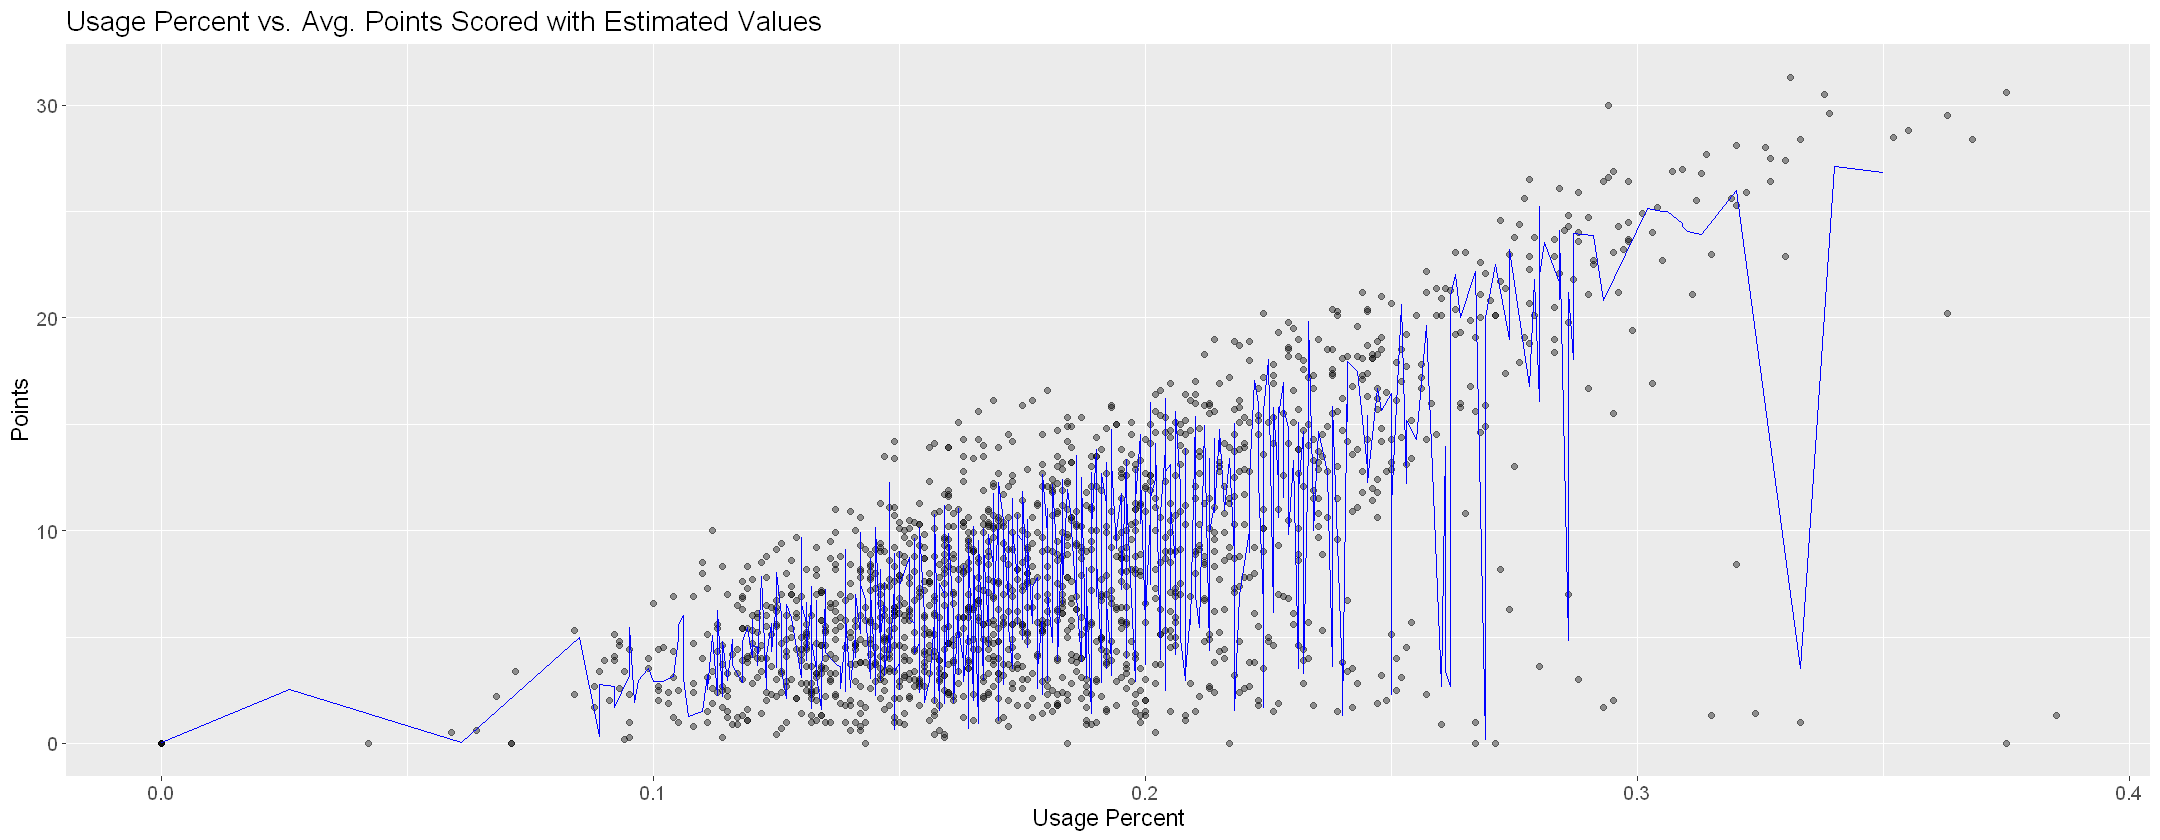

In [66]:
options(repr.plot.width = 18)

nba_predict_plot_usage <- ggplot(nba_training, aes(x = usg_pct, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = usg_pct, y = .pred), color = 'blue') +
labs(x = "Usage Percent", y = "Points") +
ggtitle("Usage Percent vs. Avg. Points Scored with Estimated Values") +
theme(text = element_text(size = 14))

nba_predict_plot_usage

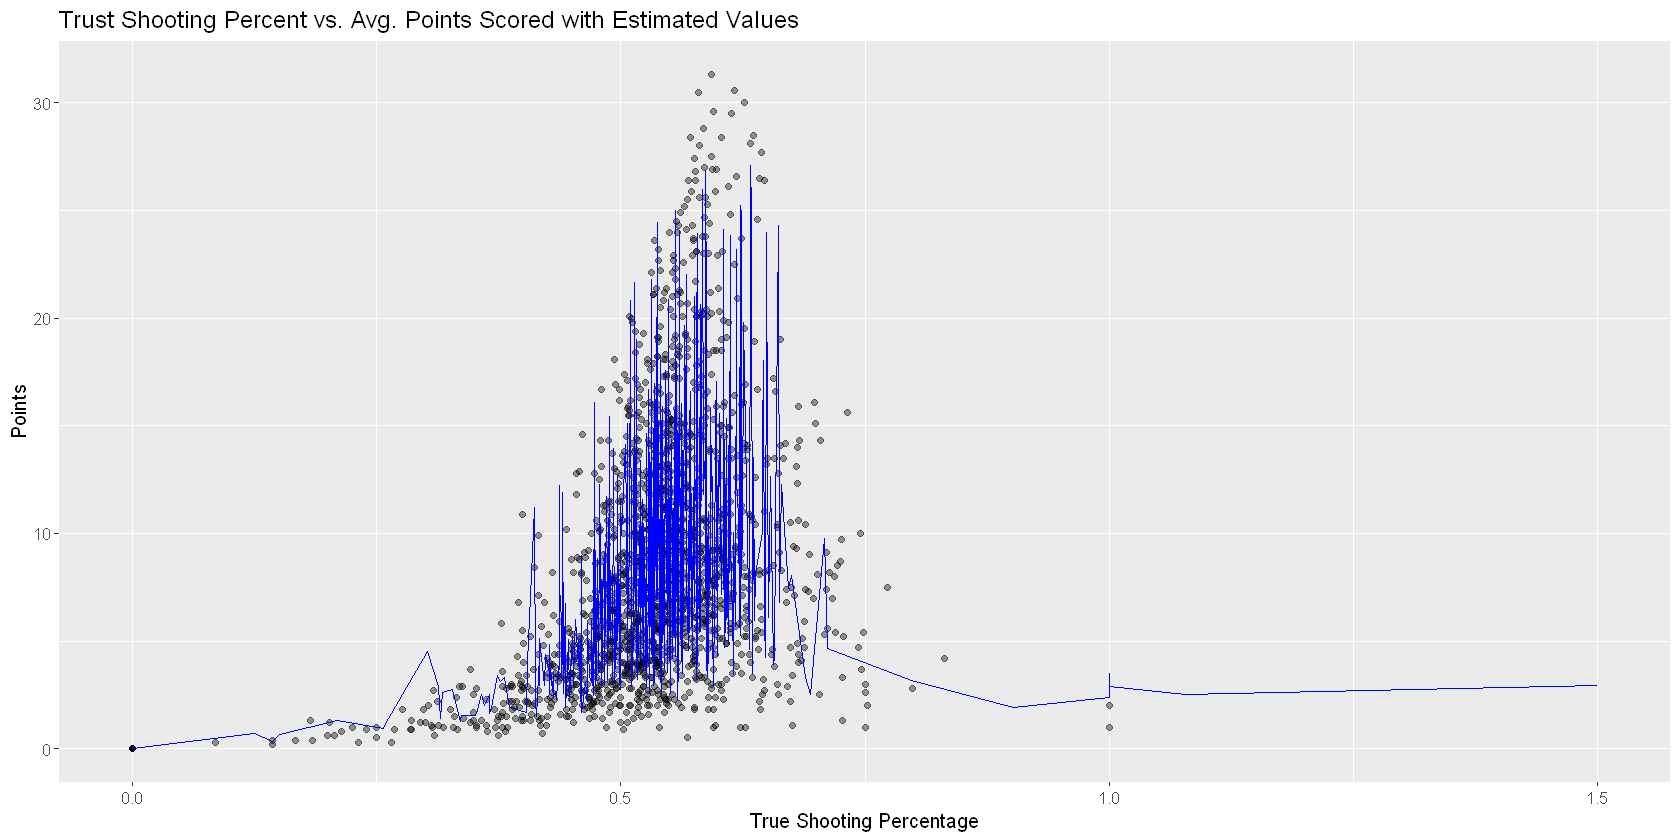

In [67]:
options(repr.plot.width = 14)

nba_predict_plot_shooting <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = ts_pct, y = .pred), color = 'blue') +
labs(x = "True Shooting Percentage", y = "Points") +
ggtitle("Trust Shooting Percent vs. Avg. Points Scored with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_shooting

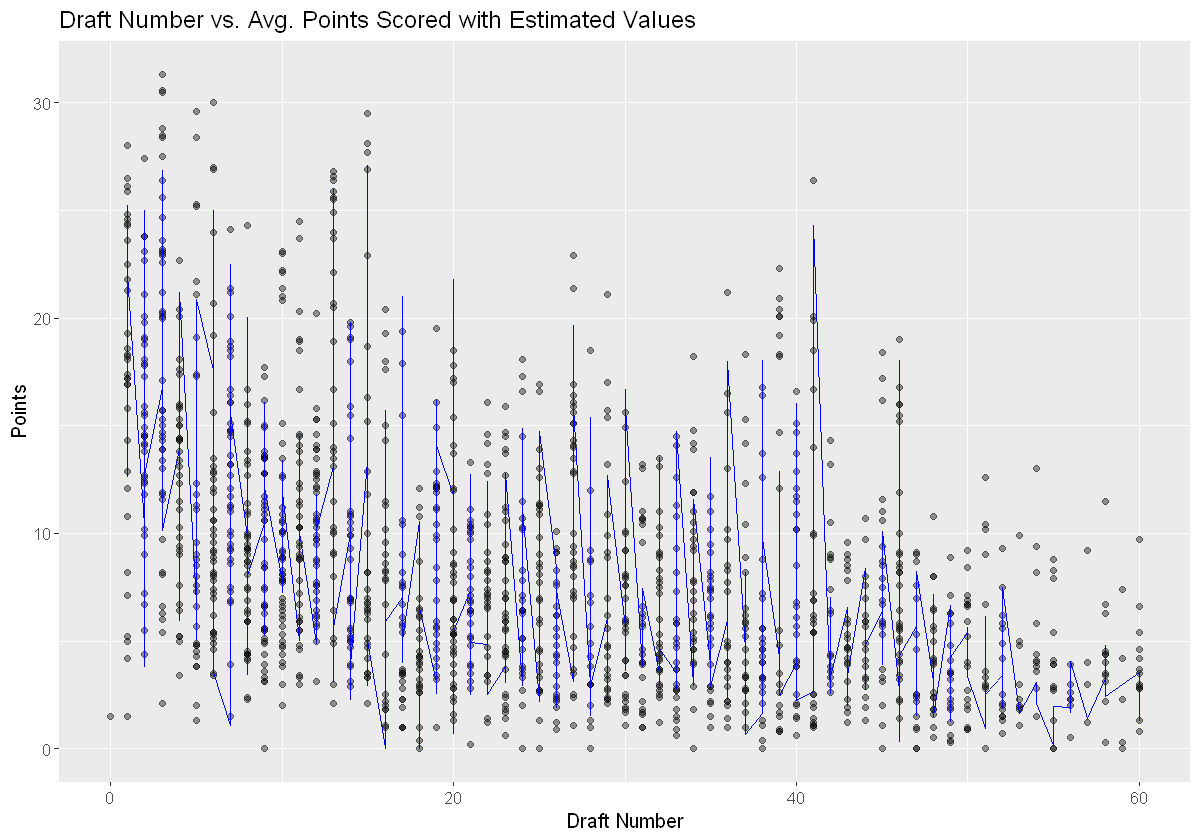

In [68]:
options(repr.plot.width = 10)
nba_predict_plot_dn <- ggplot(nba_training, aes(x = draft_number, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict, mapping = aes(x = draft_number, y = .pred), color = 'blue') +
labs(x = "Draft Number", y = "Points") +
ggtitle("Draft Number vs. Avg. Points Scored with Estimated Values") +
theme(text = element_text(size = 12))

nba_predict_plot_dn

Observe that the visualizations indicate that the data has been overplotted, with the model being heavily affected by each individual data point. Originally we attributed this to the low number of neighbors (7) relative to the data size, however, this behavior is still present even when increasing neighbors. 

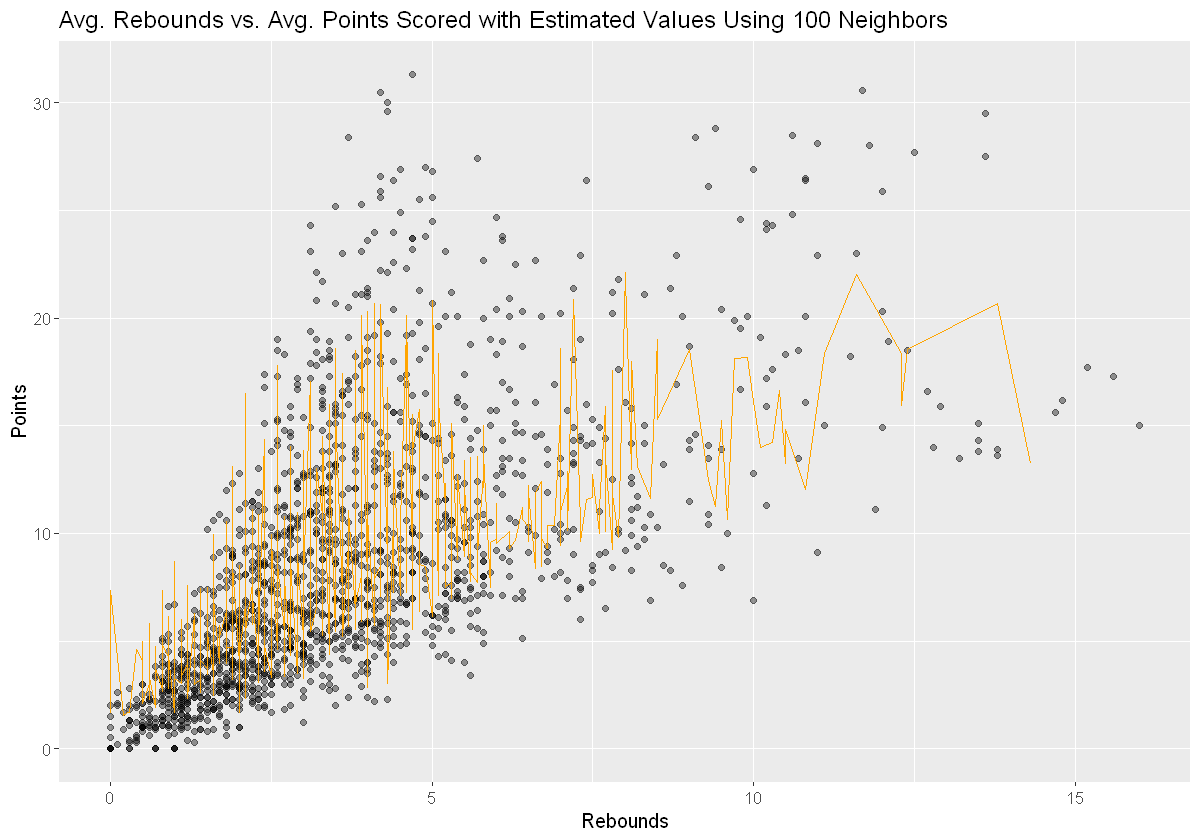

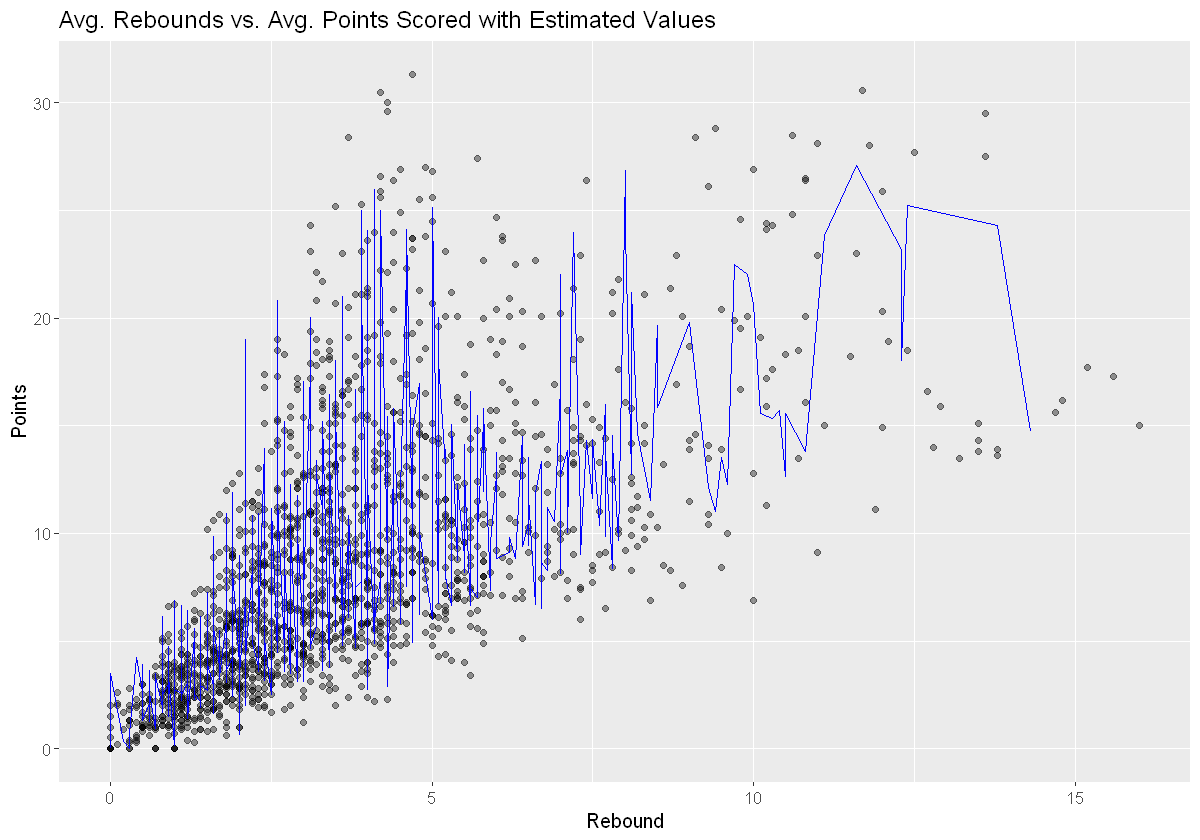

In [69]:
nba_demo_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 100) |>
  set_engine("kknn") |>
  set_mode("regression")

nba_fit_demo <- workflow() |>
  add_recipe(nba_recipe) |>
  add_model(nba_demo_spec) |>
  fit(data = nba_training)

nba_predict_demo <- nba_fit_demo |>
  predict(nba_testing) |>
  bind_cols(nba_testing)

nba_predict_demo_plot <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point(alpha = 0.4) +
geom_line(data = nba_predict_demo, mapping = aes(x = reb, y = .pred), color = 'orange') +
labs(x = "Rebounds", y = "Points") +
ggtitle("Avg. Rebounds vs. Avg. Points Scored with Estimated Values Using 100 Neighbors") +
theme(text = element_text(size = 12))


nba_predict_demo_plot
nba_predict_plot_rebound

# Discussion

Through this analysis, we determined that by using certain measurements of player performance, such as assists per game, usage percentage, true shooting percentage, and player draft number, we were able provide reasonable estimates for the player’s average points per game. `TODO: which measurements were best for analyzing performance?`

`TODO: I think we need a bit more summary of what we have found`

The final model had an RMSPE of `1.933` with our testing set. Though this is still a significant amount of error, we think that the predictions offered by this model could still be useful `((TODO: explain why))`. Although we had expected that these variables to have some capability in predicting point performance, the accuracy of the predictions was somewhat unexpected. 

These findings could have an impact on the focus of players and teams during the off-season. A team could look at trends for recent years and compare it to their own personal data, which would then allow them to make adjustments to their training routine to target factors that contribute to greater point-per-game totals, and thus more success during the season.

This analysis could lead to further questions. We believe that there is a lot more to be analyzed and formulated (as seen in more professional analysis's on the internet). Could shooting percentage be related more to rebounds than rebounds to points? Could draft number be indicative of more Usage Percentage, and thus more points? These are just a couple of questions that we could ask after looking at the results of our findings, and there are many more that could be answered.

# References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

* https://sites.northwestern.edu/nusportsanalytics/2020/12/22/an-introduction-to-advanced-basketball-statistics-individual-statistics/
  * Useful for understanding how some of the columns in the dataset are calculated.
* https://www.kaggle.com/datasets/justinas/nba-players-data
  * The dataset
* https://bleacherreport.com/articles/1813902-advanced-nba-stats-for-dummies-how-to-understand-the-new-hoops-math
  * An explanation of NBA advanced statistics that are commonly used. 
* https://projects.fivethirtyeight.com/nba-player-ratings/
  * An interesting player-analysis model by 538 for the current NBA season. Useful for seeing what professional data scientists look at for similar analysis.
